In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Part 1

Load the dataset

Drop irrelevant columns

In [2]:
df = pd.read_csv('2021_Green_Taxi_Trip_Data.csv')

irrelevant_columns = ['RatecodeID', 'store_and_fwd_flag', 'improvement_surcharge',
                      'ehail_fee', 'mta_tax', 'extra', 'fare_amount',
                      'congestion_surcharge']
df = df.drop(irrelevant_columns, axis=1)

C:\Users\frequensy\AppData\Local\Temp\ipykernel_19548\2799095637.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('2021_Green_Taxi_Trip_Data.csv')



Convert relevant columns to appropriate types

Handle specific values as requested

In [3]:
df['payment_type'] = df['payment_type'].astype(object)
df['trip_type'] = df['trip_type'].astype(object)


df.loc[(df['tip_amount'] > 0) & (df['payment_type'].isnull()), 'payment_type'] = 1
df.loc[df['passenger_count'] > 4, 'payment_type'] = 6
df.loc[df['passenger_count'] > 4, 'trip_type'] = 3
df.dropna(subset=['VendorID'], inplace=True)


Convert pickup and dropoff datetime

Extract hour/day/month from pickup_datetime

Drop original datetime columns

In [4]:
df['pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df = df[df['pickup_datetime'].dt.year == 2021]
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
print(missing_value_df)

df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_month'] = df['pickup_datetime'].dt.month


df['dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df['dropoff_hour'] = df['dropoff_datetime'].dt.hour
df['dropoff_day'] = df['dropoff_datetime'].dt.day
df['dropoff_month'] = df['dropoff_datetime'].dt.month


df.drop(columns=['lpep_pickup_datetime', 'lpep_dropoff_datetime'], inplace=True)

                                 column_name  percent_missing
VendorID                            VendorID         0.000000
lpep_pickup_datetime    lpep_pickup_datetime         0.000000
lpep_dropoff_datetime  lpep_dropoff_datetime         0.000000
PULocationID                    PULocationID         0.000000
DOLocationID                    DOLocationID         0.000000
passenger_count              passenger_count        19.926428
trip_distance                  trip_distance         0.000000
tip_amount                        tip_amount         0.000000
tolls_amount                    tolls_amount         0.000000
total_amount                    total_amount         0.000000
payment_type                    payment_type        16.344603
trip_type                          trip_type        19.926428
pickup_datetime              pickup_datetime         0.000000


Merge borough information into the main DataFrame

In [5]:
borough_df = pd.read_csv('Boroughs.csv')
df = df.merge(borough_df[['LocationID', 'Borough']], left_on='PULocationID', right_on='LocationID', how='left')
df.rename(columns={'Borough': 'PU_Borough'}, inplace=True)

df = df.merge(borough_df[['LocationID', 'Borough']], left_on='DOLocationID', right_on='LocationID', how='left')
df.rename(columns={'Borough': 'DO_Borough'}, inplace=True)


Encode boroughs

In [6]:
df = pd.get_dummies(df, columns=['PU_Borough'], prefix=['PU'], drop_first=True)
df.drop([ 'PULocationID', 'DOLocationID', 'LocationID_x', 'LocationID_y','pickup_datetime', 'dropoff_datetime' ,'DO_Borough'], axis=1, inplace=True)
print(df.columns)

Index(['VendorID', 'passenger_count', 'trip_distance', 'tip_amount',
       'tolls_amount', 'total_amount', 'payment_type', 'trip_type',
       'pickup_hour', 'pickup_day', 'pickup_month', 'dropoff_hour',
       'dropoff_day', 'dropoff_month', 'PU_Brooklyn', 'PU_EWR', 'PU_Manhattan',
       'PU_Queens', 'PU_Staten Island'],
      dtype='object')


Handle missing value using regression or classification

In [7]:
df = df.apply(pd.to_numeric, errors='coerce')
for column in df.columns:
    null_percentage = df[column].isnull().mean()
    if 0.05 < null_percentage <= 0.3:
        missing_rows = df[df[column].isnull()]
        complete_rows = df[df[column].notnull()]

        features_to_drop = [column]
        if complete_rows[column].dtype in ['int64', 'float64']:
            model = HistGradientBoostingRegressor()
            model.fit(complete_rows.drop(columns=features_to_drop, errors='ignore'), complete_rows[column])
            predicted_values = model.predict(missing_rows.drop(columns=features_to_drop, errors='ignore'))
            df.loc[df[column].isnull(), column] = predicted_values


        else:
            model = HistGradientBoostingClassifier()
            model.fit(complete_rows.drop(columns=features_to_drop, errors='ignore'), complete_rows[column])
            predicted_values = model.predict(missing_rows.drop(columns=features_to_drop, errors='ignore'))
            df.loc[df[column].isnull(), column] = predicted_values

print(df.head())
print(df.info())

   VendorID  passenger_count  trip_distance  tip_amount  tolls_amount  \
0       2.0              1.0           1.01        0.00           0.0   
1       2.0              1.0           2.53        2.81           0.0   
2       2.0              1.0           1.12        1.00           0.0   
3       2.0              3.0           0.00        0.00           0.0   
4       2.0              3.0           0.00        0.00           0.0   

   total_amount  payment_type  trip_type  pickup_hour  pickup_day  \
0          6.80           2.0        1.0            0           1   
1         16.86           1.0        1.0            0           1   
2          8.30           1.0        1.0            0           1   
3        -52.80           3.0        1.0            0           1   
4         52.80           2.0        1.0            0           1   

   pickup_month  dropoff_hour  dropoff_day  dropoff_month  PU_Brooklyn  \
0             1             0            1              1        False  


Calculate and display missing values percentage

In [8]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
print(missing_value_df)

                       column_name  percent_missing
VendorID                  VendorID              0.0
passenger_count    passenger_count              0.0
trip_distance        trip_distance              0.0
tip_amount              tip_amount              0.0
tolls_amount          tolls_amount              0.0
total_amount          total_amount              0.0
payment_type          payment_type              0.0
trip_type                trip_type              0.0
pickup_hour            pickup_hour              0.0
pickup_day              pickup_day              0.0
pickup_month          pickup_month              0.0
dropoff_hour          dropoff_hour              0.0
dropoff_day            dropoff_day              0.0
dropoff_month        dropoff_month              0.0
PU_Brooklyn            PU_Brooklyn              0.0
PU_EWR                      PU_EWR              0.0
PU_Manhattan          PU_Manhattan              0.0
PU_Queens                PU_Queens              0.0
PU_Staten Is

# Part 2
## 2.2
Plotting the Trip Type Distribution by Hour 
Trip Type Distribution by Hour 

Index(['VendorID', 'passenger_count', 'trip_distance', 'tip_amount',
       'tolls_amount', 'total_amount', 'payment_type', 'trip_type',
       'pickup_hour', 'pickup_day', 'pickup_month', 'dropoff_hour',
       'dropoff_day', 'dropoff_month', 'PU_Brooklyn', 'PU_EWR', 'PU_Manhattan',
       'PU_Queens', 'PU_Staten Island'],
      dtype='object')


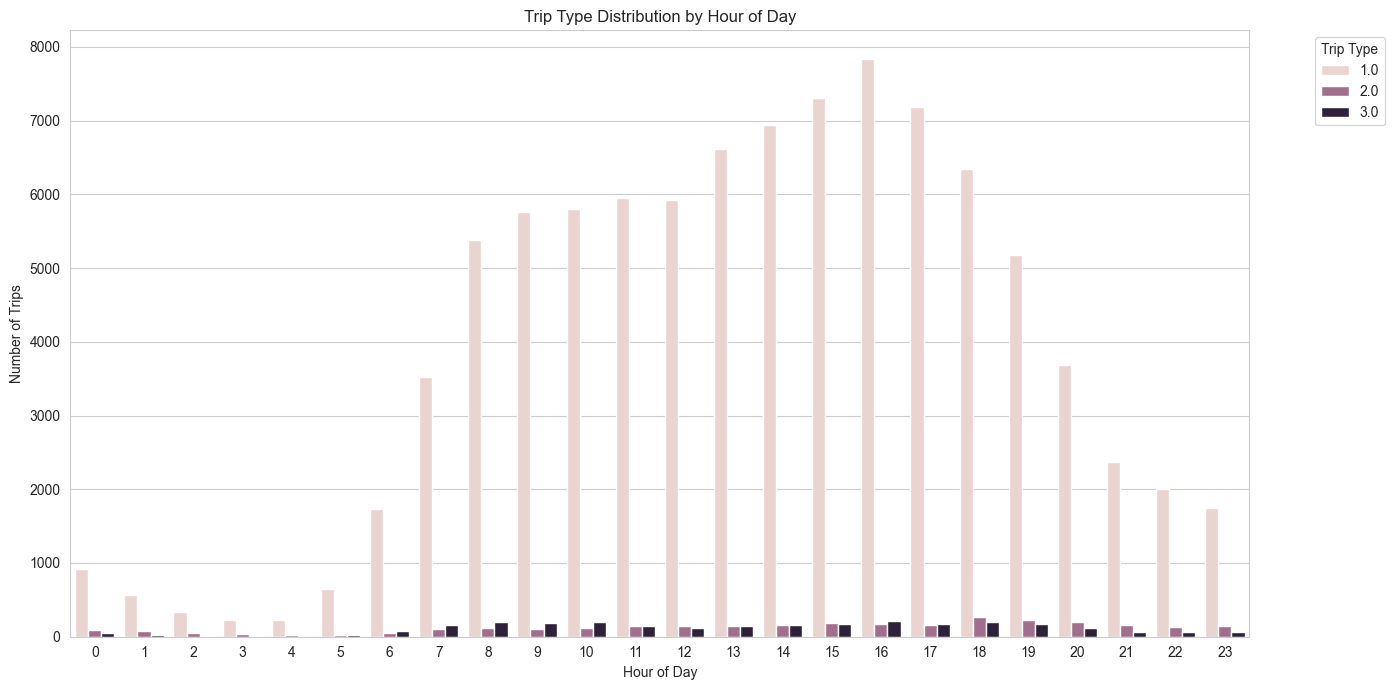

In [11]:
 
df_1=df[:100000]
print(df_1.columns)
sns.set_style("whitegrid")
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
trip_type_hourly_distribution = df_1.groupby(['pickup_hour', 'trip_type']).size().unstack(fill_value=0)
plt.figure(figsize=(14, 7))  
sns.barplot(data=trip_type_hourly_distribution.reset_index().melt(id_vars=['pickup_hour']),
            x='pickup_hour', y='value', hue='trip_type', errorbar=None)
plt.title('Trip Type Distribution by Hour of Day')  
plt.xlabel('Hour of Day')  
plt.ylabel('Number of Trips')  
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability  
plt.legend(title='Trip Type', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()  
plt.show()  


Payment Type Distribution by Hour  

Plotting the Payment Type Distribution by Hour

In [ ]:
  
payment_type_hourly_distribution = df_1.groupby(['pickup_hour', 'payment_type']).size().unstack(fill_value=0)
plt.figure(figsize=(14, 7))  
sns.barplot(data=payment_type_hourly_distribution.reset_index().melt(id_vars=['pickup_hour']),
            x='pickup_hour', y='value', hue='payment_type', ci=None)
plt.title('Payment Type Distribution by Hour of Day')  
plt.xlabel('Hour of Day')  
plt.ylabel('Number of Trips')  
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability  
plt.legend(title='Payment Type', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()  
plt.show()  

Discarding trips with trip type dispatch 

Analyzing green taxi usage by pickup hour trend

In [ ]:
taxi_df = df_1[df_1['trip_type'] != 3]
green_taxi_usage = taxi_df.groupby('pickup_hour').size()

plt.figure(figsize=(10, 6))
green_taxi_usage.plot(kind='bar', color='green')
plt.title('Green Taxi Usage by Hour of Day ')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Green Taxi Trips')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Grouping by all dummy variables for boroughs and pickup hour

In [ ]:
df_1['Pickup_Borough'] = df_1.apply(
    lambda row: 'Brooklyn' if row['PU_Brooklyn'] == 1 else
                'EWR' if row['PU_EWR'] == 1 else
                'Manhattan' if row['PU_Manhattan'] == 1 else
                'Queens' if row['PU_Queens'] == 1 else
                'Staten Island' if row['PU_Staten Island'] == 1 else
                'Bronx', axis=1
)
green_taxi_trend = df_1.groupby([ 'Pickup_Borough','pickup_hour']).size().unstack(fill_value=0)

Plotting the trend of green taxi usage by boroughs

In [ ]:
plt.figure(figsize=(14, 7))
green_taxi_trend.T.plot(kind='bar', figsize=(14, 7))
plt.title('Green Taxi Usage Trend by Borough')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()
df_1 = df_1.drop('Pickup_Borough', axis=1)

# Part 3
## 3.1
Correlation heatmap

In [ ]:
correlation_matrix = df_1.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix for Predicting Total Amount')
plt.show()

Printing columns with the highest correlation with total_amount

In [ ]:
correlation_with_total = correlation_matrix['total_amount'].sort_values(ascending=False)
print("Top correlations with total_amount:")
print(correlation_with_total)

## 3.2
1. Backward feature selection

In [ ]:

def backward_feature_selection(data, target_column='total_amount', n_features=5):
    X = data.drop(columns=[target_column])
    y = data[target_column]
    model = LinearRegression()
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    rfe.fit(X, y)
    selected_features = X.columns[rfe.support_]
    return list(selected_features)

backward_selected_features = backward_feature_selection(df_1, target_column='total_amount', n_features=5)
print("Backward Selected Features:", backward_selected_features)


2. Forward feature selection

In [ ]:

def forward_feature_selection(data, target_column='total_amount', n_features=5):
    X = data.drop(columns=[target_column])
    y = data[target_column]
    model = LinearRegression()
    selected_features = []
    remaining_features = list(X.columns)
    while len(selected_features) < n_features and remaining_features:
        best_score = -np.inf
        best_feature = None
        for feature in remaining_features:
            trial_features = selected_features + [feature]
            scores = cross_val_score(model, X[trial_features], y, cv=5, scoring='r2')
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_feature = feature
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
    return selected_features
forward_selected_features = forward_feature_selection(df_1, target_column='total_amount', n_features=5)
print("Forward Selected features:", forward_selected_features)


3. Random forest feature selection

In [ ]:

def random_forest_feature_selection(data, target_column='total_amount', n_features=5):
    X = data.drop(columns=[target_column])
    y = data[target_column]

    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X, y)

    feature_importances = pd.Series(model.feature_importances_, index=X.columns)

    selected_features = feature_importances.nlargest(n_features).index.tolist()
    return selected_features
rf_selected_features = random_forest_feature_selection(df_1, target_column='total_amount', n_features=5)
print("Random Forest Selected Features:", rf_selected_features)


4. Chi square feature selection

In [ ]:
def chi_square_feature_selection(data, target_column='pct', n_features=5):    
    if data[target_column].dtype not in ['int64', 'int32', 'bool', 'uint8']:
        data[target_column] = pd.qcut(data[target_column], q=4, labels=False)
    X = data.drop(columns=[target_column])
    y = data[target_column]
    for column in X.columns:
        if X[column].dtype in ['float64', 'int64']:
            X[column] = pd.cut(X[column], bins=5, labels=False)
        X[column] = X[column].clip(lower=0)
    chi_selector = SelectKBest(score_func=chi2, k=n_features)
    X_kbest = chi_selector.fit_transform(X, y)
    selected_features = X.columns[chi_selector.get_support()]
    return selected_features
chi_selected_features = chi_square_feature_selection(df_1, target_column='total_amount', n_features=5)
print("Chi-Square Selected Features (Chi-Square):", list(chi_selected_features))


## 3.3

In [ ]:

df_1['tip_given'] = (df_1['tip_amount'] > 0).astype(int)
X = df_1.drop(columns=['tip_given', 'tip_amount'])  # حذف ستون‌های غیرضروری
y = df_1['tip_given']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



1. Decision Tree Classifier

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Classifier Report:")
print(classification_report(y_test, y_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt))


2. Random Forest Classifier

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest Classifier Report:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

3. XGBoost Classifier

In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("\nXGBoost Classifier Report:")
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

## 3.4

Function to train and evaluate linear regression model

Split data into training and testing sets

Train Linear Regression model

Evaluation with MSE and R^2


In [ ]:
def evaluate_linear_regression(features, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.2, random_state=42)

    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    y_pred = lr_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2


Define target variable and features

Identify feature subsets from different selection methods

Evaluate Linear Regression for each feature subset

Convert results to a DataFrame

In [ ]:
y = df_1['total_amount']
X = df_1.drop(columns=['total_amount'])


feature_selection_methods = {
    'Backward': backward_selected_features,
    'Forward': forward_selected_features,
    'Random Forest': rf_selected_features,
    'Chi-Square': list(chi_selected_features)
}


results = []
for method, features in feature_selection_methods.items():
    mse, r2 = evaluate_linear_regression(features, X, y)
    results.append({'Method': method, 'MSE': mse, 'R^2': r2})

results_df = pd.DataFrame(results)

Find the best feature set based on MSE

In [ ]:
best_method = results_df.loc[results_df['MSE'].idxmin()]
best_features = feature_selection_methods[best_method['Method']]

print("Feature Selection Results:")
print(results_df)
print("\nBest Feature Set Based on MSE:")
print(f"Method: {best_method['Method']}, MSE: {best_method['MSE']}, R^2: {best_method['R^2']}")


Integrate the best Linear Regression model with Random Forest and XGBoost for comparison
1. Train and evaluate the best Linear Regression model

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X[best_features], y, test_size=0.2, random_state=42)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 2. Random Forest Regressor

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

3. XGBoost Regressor

In [ ]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_r2 = r2_score(y_test, y_pred_xgb)

Comparison of models.

In [ ]:
comparison_results = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'Mean Squared Error': [lr_mse, rf_mse, xgb_mse],
    'R^2 Score': [lr_r2, rf_r2, xgb_r2]
}
comparison_df = pd.DataFrame(comparison_results)

print("\nModel Comparison:")
print(comparison_df)
best_model = comparison_df.loc[comparison_df['Mean Squared Error'].idxmin()]

Displaying the best model based on MSE.

In [ ]:

print("\nBest Model Based on MSE:")
print(f"Method: {best_model['Model']}, MSE: {best_model['Mean Squared Error']:.4f}, R^2: {best_model['R^2 Score']:.4f}")

Showing the 10 most important features and how important they are.

In [ ]:
rf_importances = pd.Series(rf_model.feature_importances_,index=X.columns)
xgb_importances = pd.Series(xgb_model.feature_importances_,index=X.columns)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
rf_importances.nlargest(10).plot(kind='bar', title='Random Forest Feature Importances')
plt.subplot(1, 2, 2)
xgb_importances.nlargest(10).plot(kind='bar', title='XGBoost Feature Importances')
plt.tight_layout()
plt.show()

## 3.5
Specifying a parameter grid, containing potential parameter values so that the algorithm iterates over it.
Getting the best parameters as an output.

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, verbose=1)
grid_search.fit(X_train, y_train)


print(f"Best parameters found: {grid_search.best_params_}")

Now, we calculate the Mean Square Error and Root Mean Squared Error of the model with the best parameters.

In [ ]:
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
